In [1]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import time
from datasets import find_dataset_def
from models import *
from utils import *
import sys
from datasets.data_io import read_pfm, save_pfm
import cv2
from plyfile import PlyData, PlyElement
from PIL import Image

In [2]:
from pyquaternion import Quaternion
import matplotlib.pyplot as plt

from python.read_write_model import *
from python.read_dense import *

from PIL import Image

## load colmap result

In [3]:
input_model = "../TestMap/sparse"
input_format = ".bin"
image_folder = "../TestMap/images/"
depth_folder = "../TestMap/mvs/tv_depths/"

In [4]:
cameras, images, points3D = read_model(path=input_model, ext=input_format)
print("num_cameras:", len(cameras))
print("num_images:", len(images))
print("num_points3D:", len(points3D))

num_cameras: 351
num_images: 351
num_points3D: 27470


In [5]:
def q_t_to_matrix(q_vec, t_vec):
    quaternion = Quaternion(q_vec)
    pose = np.eye(4)
    pose[0:3,0:3] = quaternion.rotation_matrix
    pose[0:3, 3] = t_vec
    #pose = np.linalg.inv(pose)
    return pose

In [6]:
def read_img(filename, b_dtu = False):
    img = Image.open(filename)
    # scale 0~255 to 0~1
    np_img = np.array(img, dtype=np.float32) / 255.
    if(b_dtu):
        assert np_img.shape[:2] == (1200, 1600)
        # crop to (1184, 1600)
        np_img = np_img[:-16, :]  # do not need to modify intrinsics if cropping the bottom part
    return np_img

In [7]:
def read_cam_file(filename, interval_scale=1.06):
    with open(filename) as f:
        lines = f.readlines()
        lines = [line.rstrip() for line in lines]
    # extrinsics: line [1,5), 4x4 matrix
    extrinsics = np.fromstring(' '.join(lines[1:5]), dtype=np.float32, sep=' ').reshape((4, 4))
    # intrinsics: line [7-10), 3x3 matrix
    intrinsics = np.fromstring(' '.join(lines[7:10]), dtype=np.float32, sep=' ').reshape((3, 3))
    intrinsics[:2, :] /= 4
    # depth_min & depth_interval: line 11
    depth_min = float(lines[11].split()[0])
    depth_interval = float(lines[11].split()[1]) * interval_scale
    return intrinsics, extrinsics, depth_min, depth_interval

In [8]:
def numpy2tensor(input_py, device):
    return torch.from_numpy(input_py).float().to(device)

In [9]:
# # make a test query
# datapath = "dtu"
# scan = "scan1"
# vid_length = 5

# ndepths = 10
# count = 0
# imgs_db = []
# proj_matrices_db = []
# for vid in range(vid_length):
#     img_filename = os.path.join(datapath, '{}/images/{:0>8}.jpg'.format(scan, vid))
#     proj_mat_filename = os.path.join(datapath, '{}/cams/{:0>8}_cam.txt'.format(scan, vid))

#     image = read_img(img_filename, True)
#     imgs_db.append(image)
    
#     intrinsics, extrinsics, depth_min, depth_interval = read_cam_file(proj_mat_filename)
    
#     proj_mat = extrinsics.copy()
#     proj_mat[:3, :4] = np.matmul(intrinsics, proj_mat[:3, :4])
#     proj_matrices_db.append(proj_mat)
    
#     if count == 0:  # reference view
#         depth_values = np.arange(depth_min, depth_interval * (ndepths - 0.5) + depth_min, depth_interval,
#                                          dtype=np.float32)
    
# imgs_db = np.stack(imgs_db).transpose([0, 3, 1, 2])
# proj_matrices_db = np.stack(proj_matrices_db)
# device = "cuda"
# test_data_db = {"imgs": numpy2tensor(imgs_db,device),
#                 "proj_matrices": numpy2tensor(proj_matrices_db,device),
#                 "depth_values": numpy2tensor(depth_values, device)}

# for k in test_data_db.keys():
#     test_data_db[k] = torch.unsqueeze(test_data_db[k], 0)

In [10]:
loadckpt = "models/model_000014.ckpt"

In [11]:
# model
model = MVSNet(refine=False)
model = nn.DataParallel(model)
model.cuda()

# load checkpoint file specified by args.loadckpt
print("loading model {}".format(loadckpt))
state_dict = torch.load(loadckpt)
model.load_state_dict(state_dict['model'])
model.eval()

loading model models/model_000014.ckpt


DataParallel(
  (module): MVSNet(
    (feature): FeatureNet(
      (conv0): ConvBnReLU(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): ConvBnReLU(
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): ConvBnReLU(
        (conv): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv3): ConvBnReLU(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv4): ConvBnReLU(
        (conv): Conv2d(16, 

I try to test the offered dataset, while it consumes too much GPU memory, as I result I will never actually run it with my GTX1080 8G GPU.

In [19]:
# outputs = model(test_data_db["imgs"], test_data_db["proj_matrices"], test_data_db["depth_values"])
# outputs = tensor2numpy(outputs)
# plt.figure(figsize=(10,5))
# plt.subplot(121)
# plt.imshow(outputs['depth'][0])
# plt.subplot(122)
# plt.imshow(outputs['photometric_confidence'][0])

As I have no information about the input pose should be Tcw or Twc, so I test the two of them, 
and they results in the same terrible results.

In [18]:
# make a test query

# as I have no information about the input pose should be Tcw or Twc, so I test the two of them, 
# and they results in the same terrible results
ndepths = 120
count = 0
imgs = []
proj_matrices = []
for image_id, image_data in images.items():
    if(image_id < 200):
        continue
    pose_camera = np.linalg.inv(q_t_to_matrix(image_data.qvec, image_data.tvec*0.1)) #np.linalg.inv
    image_file = image_folder + "/" + image_data.name

    image = read_img(image_file)
    imgs.append(image)
    
    camera_param = cameras[image_data.camera_id].params
    intrinsics = np.eye(3).astype(np.float32)
    intrinsics[0,0] = camera_param[0];intrinsics[1,1] = camera_param[0]
    intrinsics[0,2] = camera_param[1];intrinsics[1,2] = camera_param[2]
    
    extrinsics = pose_camera.astype(np.float32)
    
    depth_min = 425
    interval_scale = 1.06
    depth_interval = 2.5 * interval_scale
    
    proj_mat = extrinsics.copy()
    proj_mat[:3, :4] = np.matmul(intrinsics, proj_mat[:3, :4])
    proj_matrices.append(proj_mat)
    
    if count == 0:  # reference view
        depth_values = np.arange(depth_min, depth_interval * (ndepths - 0.5) + depth_min, depth_interval,
                                         dtype=np.float32)
    
    count += 1
    if count > 10:
        break
imgs = np.stack(imgs).transpose([0, 3, 1, 2])
proj_matrices = np.stack(proj_matrices)
device = "cuda"
test_data = {"imgs": numpy2tensor(imgs,device),
                "proj_matrices": numpy2tensor(proj_matrices,device),
                "depth_values": numpy2tensor(depth_values, device)}

for k in test_data.keys():
    test_data[k] = torch.unsqueeze(test_data[k], 0)

D:\programs\Anaconda\lib\site-packages\torch\nn\functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


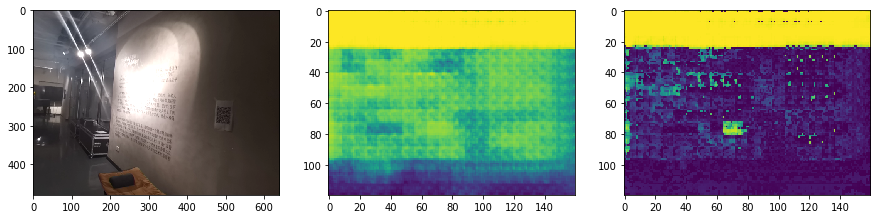

In [14]:
outputs = model(test_data["imgs"], test_data["proj_matrices"], test_data["depth_values"])
outputs = tensor2numpy(outputs)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(imgs[0].transpose([1,2,0]))
plt.subplot(132)
plt.imshow(outputs['depth'][0])
plt.subplot(133)
plt.imshow(outputs['photometric_confidence'][0])

In [15]:
def make_image(depth_ref, intrinsics_ref):
    width, height = depth_ref.shape[1], depth_ref.shape[0]
    ## step1. project reference pixels to the source view
    # reference view x, y
    x_ref, y_ref = np.meshgrid(np.arange(0, width), np.arange(0, height))
    x_ref, y_ref = x_ref.reshape([-1]), y_ref.reshape([-1])
    # reference 3D space
    xyz_ref = np.matmul(np.linalg.inv(intrinsics_ref),
                        np.vstack((x_ref, y_ref, np.ones_like(x_ref))) * depth_ref.reshape([-1]))
    return xyz_ref

In [16]:
import open3d as o3d

In [17]:
points = make_image(outputs['depth'][0], intrinsics)
point_cloud_o3d = o3d.geometry.PointCloud()
point_cloud_o3d.points = o3d.utility.Vector3dVector(points.transpose().tolist())
o3d.visualization.draw_geometries([point_cloud_o3d])

![image colmap](images/test_colmap.png)